# Milestone 1: Project Propsal and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlite3 import connect

sns.set_theme(style='darkgrid')

Let's read the .csv files

In [2]:
regions = pd.read_csv('SportsStats/noc_regions.csv', sep=',')
events = pd.read_csv('SportsStats/athlete_events.csv', sep=',')

Let's take a look to the regions dataframe.

In [3]:
regions.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [4]:
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


Let's take a look to the events dataframe

In [5]:
events.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [7]:
events['Sport'].value_counts()

Athletics        38624
Gymnastics       26707
Swimming         23195
Shooting         11448
Cycling          10859
                 ...  
Racquets            12
Jeu De Paume        11
Roque                4
Basque Pelota        2
Aeronautics          1
Name: Sport, Length: 66, dtype: int64

Let's drop some columns and generate SQL tables, and add an 'Event_ID' column to them to work as a PK on the Event Table and as FK in the Athletes Table.

In [8]:
Athletes = events.drop(['Team','Games'], axis=1,inplace=False)
Athletes.insert(loc=1, column="Event_ID", value=range(1, 1 + len(Athletes)), allow_duplicates=False)
Event = events.drop(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games', 'Medal'], axis=1,inplace=False)
Event.insert(loc=1, column="Event_ID", value=range(1, 1 + len(Event)), allow_duplicates=False)

In [9]:
engine = connect(':memory:')

In [10]:
Athletes.to_sql('AthletesTable', con=engine)
Event.to_sql('EventTable', con=engine)

271116

Let's find some quick statistics in the from the Tables making use of SQL. For example the ratio of male-female Athletes.

In [11]:
pd.read_sql('''
SELECT 
    sex,
    COUNT(*)                              AS  count,    
    COUNT(*)*100.0/SUM(COUNT(*)) OVER ( ) AS 'percentage (%)'
FROM 
    AthletesTable
GROUP BY 
    sex
''', con=engine)

,Sex,count,percentage (%)
0,F,74522,27.487127
1,M,196594,72.512873


Or the average age, height and weight, per sport in the Games.

In [12]:
pd.read_sql('''
SELECT 
    sport,
    AVG(age)    AS '<age>',
    AVG(height) AS '<height>',
    AVG(weight) AS '<weight>'
FROM 
    AthletesTable
GROUP BY 
    sport
''',con=engine)

,Sport,<age>,<height>,<weight>
0,Aeronautics,26.000000,NaN,NaN
1,Alpine Skiing,23.205462,173.489052,72.068110
2,Alpinism,38.812500,NaN,NaN
3,Archery,27.935226,173.203085,70.011135
4,Art Competitions,45.901009,174.644068,75.290909
...,...,...,...,...
61,Tug-Of-War,29.309524,182.480000,95.615385
62,Volleyball,25.183800,186.994822,78.900214
63,Water Polo,25.659627,184.834648,84.566446
64,Weightlifting,25.502010,167.824801,78.726663


We can check also the percentage of NULL values in the Age, Height and Weight columns

In [13]:
pd.read_sql('''
SELECT 
    COUNT(*) AS total_entries,
    (COUNT(*)-COUNT(age))*100/COUNT(*)          AS NULL_age,
    (COUNT(*)-COUNT(height))*100/COUNT(*)       AS NULL_height,
    (COUNT(*)-COUNT(weight))*100/COUNT(*)       AS NULL_weight
FROM 
    AthletesTable
''', con=engine)

,total_entries,NULL_age,NULL_height,NULL_weight
0,271116,3,22,23


______________________________________________________________________________________


# Milestone 2: Descriptive Stats

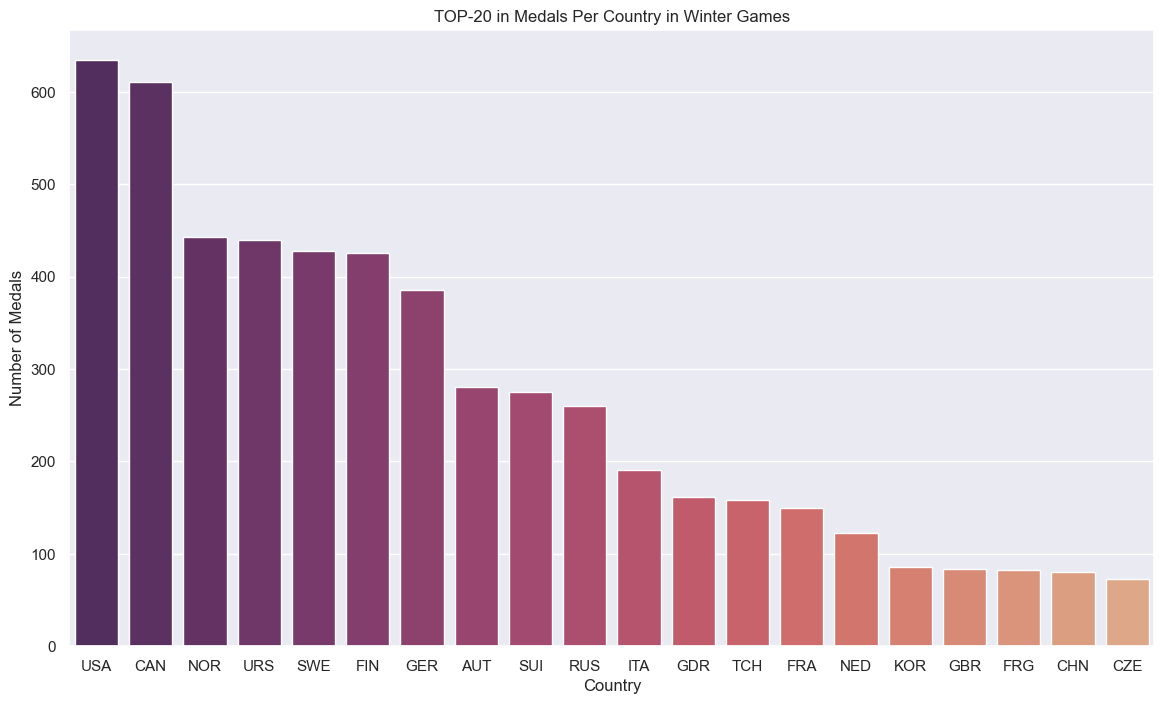

In [14]:
medal_winter = pd.read_sql('''
SELECT
    NOC,
    medal_count
FROM (
    SELECT
        NOC,
        COUNT(*) AS total_count,
        SUM(CASE WHEN medal IS NOT NULL 
                 THEN 1 ELSE 0
                 END) AS medal_count
    FROM
        AthletesTable
    WHERE
        season = 'Winter'
    GROUP BY
        NOC
    ) AS medals
WHERE NOC IS NOT NULL
ORDER BY medal_count DESC
LIMIT 20
''', con=engine)

plt.figure(figsize=[14,8])
sns.color_palette("rocket")
sns.barplot(x=medal_winter['NOC'], y = medal_winter['medal_count'], palette="flare_r")
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.title('TOP-20 in Medals Per Country in Winter Games')
plt.show()

In [15]:
medal_age = pd.read_sql('''
SELECT
    age,
    sex,
    medal_count,
    CAST(medal_count AS float)*100 / 271116 AS ratio
FROM (
    SELECT
        age,
        sex,
        COUNT(*) AS total_count,
        SUM(CASE
              WHEN medal IS NOT NULL THEN 1 ELSE 0
            END) AS medal_count
    FROM
        AthletesTable
    GROUP BY
        age
    ) AS medals
WHERE age IS NOT NULL
''', con=engine)

medal_age

,age,sex,medal_count,ratio
0,10.0,M,1,0.000369
1,11.0,F,1,0.000369
2,12.0,F,6,0.002213
3,13.0,F,16,0.005902
4,14.0,F,75,0.027663
...,...,...,...,...
69,81.0,M,0,0.000000
70,84.0,M,0,0.000000
71,88.0,M,0,0.000000
72,96.0,M,0,0.000000


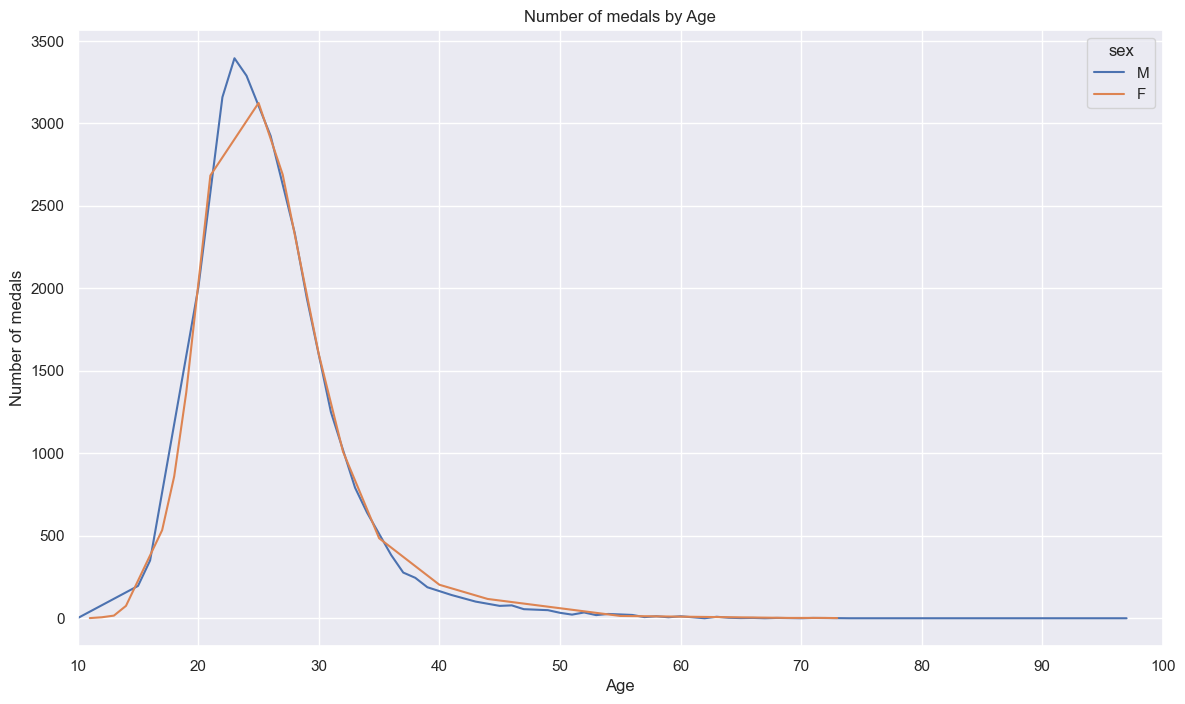

In [16]:

plt.figure(figsize=[14,8])

sns.lineplot(x=medal_age['age'], y=medal_age['medal_count'], hue=medal_age['sex'])
plt.xlabel('Age')
plt.ylabel('Number of medals')
plt.xlim(10,100)
plt.title('Number of medals by Age')
plt.show()

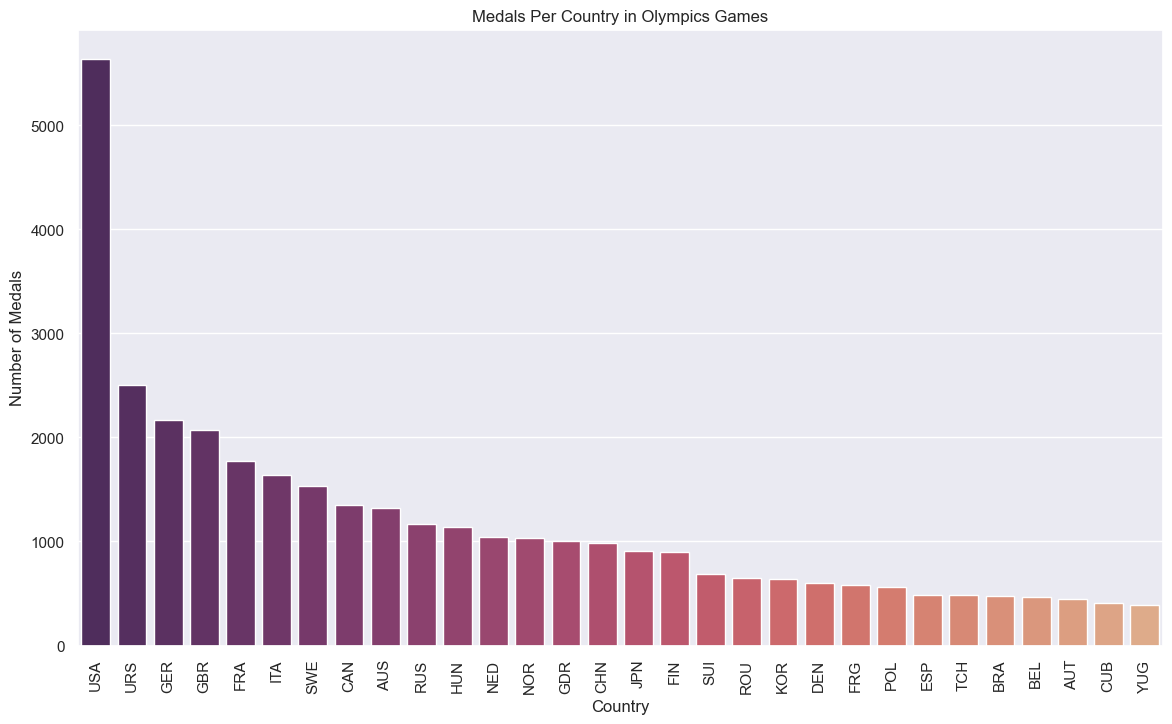

In [17]:
medal_winter = pd.read_sql('''
SELECT
    NOC,
    medal_count
FROM (
    SELECT
        NOC,
        COUNT(*) AS total_count,
        SUM(CASE WHEN medal IS NOT NULL 
                 THEN 1 ELSE 0
                 END) AS medal_count
    FROM
        AthletesTable
    GROUP BY
        NOC
    ) AS medals
WHERE NOC IS NOT NULL
ORDER BY medal_count DESC
LIMIT 30
''', con=engine)


plt.figure(figsize=[14,8])
sns.barplot(x=medal_winter['NOC'], y = medal_winter['medal_count'], palette="flare_r")
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Number of Medals')
plt.title('Medals Per Country in Olympics Games')
plt.show()

In [18]:
genre_count = pd.read_sql('''
SELECT
    Year,
    SUM(CASE WHEN sex = 'M' THEN 1 ELSE 0 END) AS male_count,
    SUM(CASE WHEN sex = 'F' THEN 1 ELSE 0 END) AS female_count    
FROM
    AthletesTable
GROUP BY
    Year
''', con=engine)


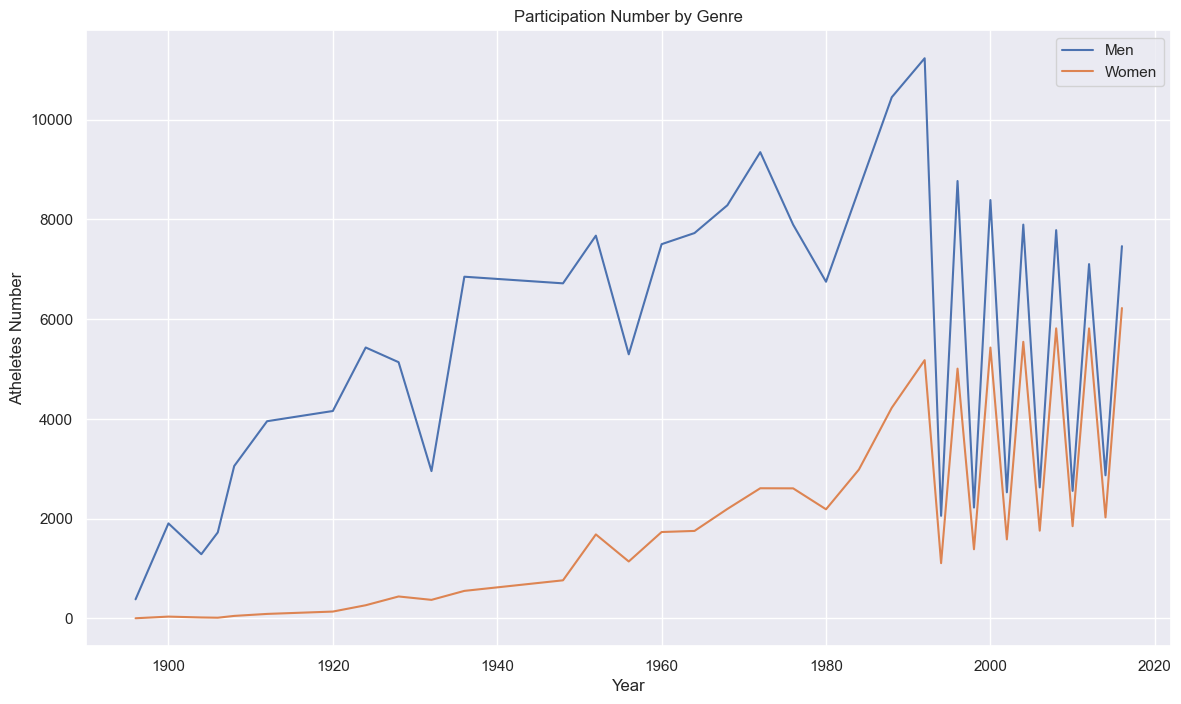

In [19]:
plt.figure(figsize=[14,8])
sns.lineplot(x=genre_count['Year'], y=genre_count['male_count'], label='Men')
sns.lineplot(x=genre_count['Year'], y=genre_count['female_count'], label='Women')
plt.xlabel('Year')
plt.ylabel('Atheletes Number')
plt.title('Participation Number by Genre')
plt.show()


----------------------------

# Milestone 3: Beyond Descriptive Stats